In [ ]:
!pip install ipython-sql

In [ ]:
import psycopg2
import boto3
import json
import pandas as pd
import numpy as np
import random

In [ ]:
%load_ext sql
client = boto3.client('secretsmanager')
secrets=client.get_secret_value(SecretId='<Insert your AWS secret for your RDS db here')
PGUSER=json.loads(secrets['SecretString'])['username']
PGPASSWORD=json.loads(secrets['SecretString'])['password']
PGHOST = '<Insert your host name here>'
PGDATABASE = 'postgres'
connectString=f'postgresql://{PGUSER}:{PGPASSWORD}@{PGHOST}/{PGDATABASE}'
%sql $connectString

# Generate Random Creator and Video Data

## Creators

### Name Generator

The code below takes in names from [NYC public data](https://catalog.data.gov/dataset/popular-baby-names/resource/02e8f55e-2157-4cb2-961a-2aabb75cbc8b), creates random pairings and ensures there are no duplicates

In [ ]:
numCreators=10000 #Use this to define the number of creators to make

In [56]:
names=pd.read_csv('Popular_Baby_Names.csv') 
nameList=names["Child's First Name"].str.title().unique()
nameListFinal=[]
for i in range(0,numCreators):
    dup=True
    while dup==True:
        name=random.choice(nameList)+' '+random.choice(nameList)
        if name not in nameListFinal:
            nameListFinal.append(name)
            dup=False

### Creator Table
Using the data above, we'll make a "creators" table with the following additional fields:
    
    * name: created from the list above
    * creator_country_code: randomly assigned from the top 30 most populous countries
    * creator_category: randomly assigned from 8 pre-defined categories
    * followers: randomly generated
    * views: randomly generated
    * comments: randomly generated
    * videos: randomly generated    

In [57]:
creators=pd.DataFrame(range(1,numCreators+1),columns=['creator_id'])

In [58]:
creators['name']=nameListFinal


In [59]:
countries=['CN','IN','US','ID','PK','BR','NG','BD','RU','MX'
            ,'JP','ET','PH','EG','VN','CD','TR','IR','DE','TH'
            ,'GB','FR','IT','TZ','ZA','MM','KE','KR','CO','AR','UG']
creators['creator_country_code']=np.random.choice(countries, size=len(creators))

In [60]:
categories=['Politics','Celebrity','Gaming','Lifestyle','Travel','Food','Comedy','Sports']
creators['creator_category']=np.random.choice(categories, size=len(creators))

In [61]:
creators['followers']=(10000000*np.random.rand(1,numCreators)[0]).round()
creators['views']=(10000000000*np.random.rand(1,numCreators)[0]).round()
creators['comments']=(1000000*np.random.rand(1,numCreators)[0]).round()
creators['videos']=(100*np.random.rand(1,numCreators)[0]).round()


### Upload to Postgres
Uploaded the dataframe to postgres and created an index on the creator_id for fast recall.

In [63]:
%sql drop table if exists creators CASCADE;
%sql --persist creators
%sql alter table creators drop column index;
%sql create index on creators (creator_id);

[]

In [47]:
##Originally attempted this is SQL, but became too messy. Saved for reference
##%%sql
##drop table if exists creators CASCADE;
##create table creators as
##SELECT 
##     creator_id
##    ,(array['CN','IN','US','ID','PK','BR','NG','BD','RU','MX'
##            ,'JP','ET','PH','EG','VN','CD','TR','IR','DE','TH'
##            ,'GB','FR','IT','TZ','ZA','MM','KE','KR','CO','AR','UG'])[floor(random() * 3 + 1)] country_code
##    ,(array['Politics','Celebrity','Gaming','Lifestyle','Travel','Food','Comedy','Sports'])[floor(random() * 3 + 1)] category    
##    ,round(random()*10000000)::INT  followers
##    ,round(random()*100000000)::INT  views
##    ,round(random()*1000000)::INT  comments
##    ,round(random()*100)::INT videos
##FROM generate_series(1, 10000) as t(creator_id)
##;

Done.
10000 rows affected.


[]

In [107]:
%%sql
select
*
from
creators
limit 10

10 rows affected.


creator_id,name,creator_country_code,creator_category,followers,views,comments,videos
1,Gitty Anne,BD,Sports,4419215.0,61983182.0,689203.0,14.0
2,Yisroel Messiah,CO,Comedy,3488777.0,34782627.0,51256.0,48.0
3,Sean Brynn,KR,Lifestyle,621140.0,83891267.0,659423.0,40.0
4,Avraham Anthony,UG,Food,307605.0,64532522.0,90337.0,98.0
5,Pinchas Isabel,TH,Travel,6296997.0,56199950.0,670438.0,71.0
6,Mackenzie Christian,CO,Food,825613.0,80138547.0,621399.0,51.0
7,Jesse Muhammad,EG,Travel,4086099.0,58640990.0,439422.0,22.0
8,Julianna Hope,IT,Food,9393573.0,97815107.0,138454.0,81.0
9,Carmen Judah,PK,Celebrity,83155.0,96678901.0,721297.0,47.0
10,Pinchus Kayla,CD,Lifestyle,1224307.0,64190752.0,149065.0,97.0


## Videos
Fields:

    - video_id
    - creator_id
    - video_length_seconds 

In [14]:
numVideos=100000 #Use this to set the number of videos you want to create. 100k took about 20-30minutes on my setupvideo_length_seconds

In [15]:
%%sql
drop table if exists videos;
create table videos as
SELECT 
     video_id
    ,round(random()*10000)::INT creator_id
    ,(120*random())::INT video_length_seconds
FROM 
    generate_series(1, :numVideos) as t(video_id)   
;



Done.
100000 rows affected.


[]

In [19]:
%%sql
select * from videos
limit 10

10 rows affected.


video_id,creator_id,video_length_seconds
1,6019,24
2,8009,58
3,724,99
4,5591,2
5,7703,33
6,8490,118
7,5212,112
8,5689,15
9,1248,10
10,9796,24


## Time Variations

In order to add some random variability, we'll create a monthly multiplier using historical NASDAQ data

In [22]:
# Set the start and end dates
nasdStart='2022-01-01'
nasdEnd=pd.to_datetime('today').strftime('%Y-%m-%d') #Today's date

In [ ]:
!pip install yfinance

In [19]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


[*********************100%%**********************]  1 of 1 completed
                    Open          High           Low         Close  \
Date                                                                 
2022-01-03  15732.500000  15832.799805  15644.089844  15832.799805   
2022-01-04  15852.139648  15852.139648  15512.410156  15622.719727   
2022-01-05  15547.160156  15586.299805  15095.179688  15100.169922   
2022-01-06  15024.150391  15198.450195  14914.870117  15080.860352   
2022-01-07  15095.719727  15171.019531  14877.629883  14935.900391   
...                  ...           ...           ...           ...   
2023-11-09  13693.700195  13697.820312  13506.019531  13521.450195   
2023-11-10  13571.190430  13802.530273  13556.349609  13798.110352   
2023-11-13  13745.959961  13805.110352  13687.780273  13767.740234   
2023-11-14  14015.370117  14124.059570  14003.139648  14094.379883   
2023-11-15  14147.269531  14194.360352  14060.700195  14103.839844   

               Adj C

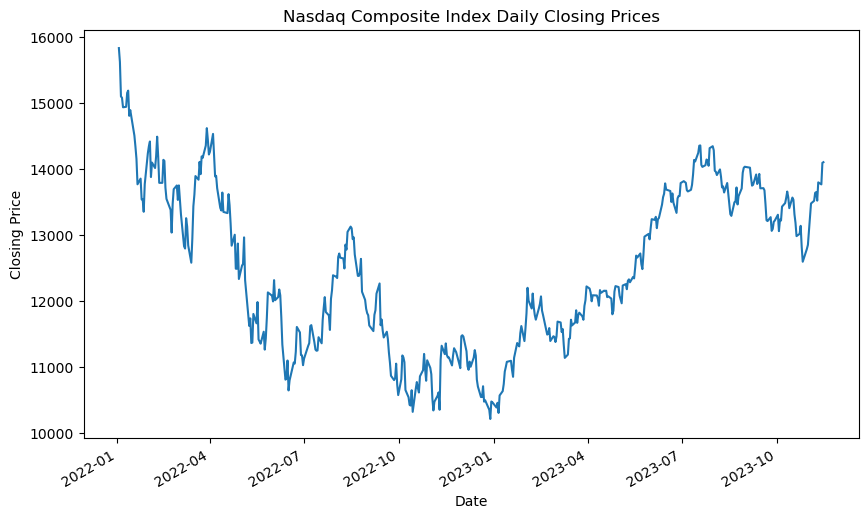

In [24]:
# Define the stock symbol (Nasdaq Composite Index)
stock_symbol = '^IXIC'

# Download historical data
nasd_multipiers = yf.download(stock_symbol, start=nasdStart, end=nasdEnd)

# Display the data
print(nasd_multipiers)

# Plot the closing prices
nasd_multipiers['Close'].plot(figsize=(10, 6), title='Nasdaq Composite Index Daily Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [25]:
nasd_multipiers=nasd_multipiers.reset_index()

In [26]:
nasd_multipiers['multiplier']=nasd_multipiers['Close']/nasd_multipiers['Close'].sum()

In [28]:
%sql drop table if exists nasd_multipiers;
%sql --persist nasd_multipiers

Done.


'Persisted nasd_multipiers'

In [30]:
%%sql
drop table if exists nasd_multipiers_clean;
create table nasd_multipiers_clean as
select
     date_trunc('month',nasd_multipiers."Date"::date)::date as nasd_month
    ,avg(multiplier) multiplier
from 
    nasd_multipiers        
where 
    nasd_multipiers."Date"::date>=:nasdStart
    and nasd_multipiers."Date"::date<=:nasdEnd
            
group by 1

Done.
23 rows affected.


[]

# Device and Container Distributions
I wanted to add some dimensions and predefined distributions that would add more variability to that data: 

    - context -> Where in the app user viewed the video
        - Feed: 60% of plays
        - Creator Page: 30% of plays
        - Other: 10% of plays
    - platform -> The type of device the user viewed the video on
        - Mobile: 70% of plays
        - Web: 25% of plays
        - Other: 5% of plays 

In [20]:
%%sql
drop table if exists context;
create table context as
select *
from
(values ('Feed',.6),('Creator Page',.3),('Other',.1)) as c (context,context_distribution)  
;


Done.
3 rows affected.


[]

In [24]:
%%sql
drop table if exists platform;
create table platform as
select *
from
(values ('Mobile',.7),('Web',.25),('Other',.05)) as c (platform,platform_distribution)  
;


Done.
3 rows affected.


[]

# Population Based Country Breakout

I wanted to create geographic user breakouts and will make the count of users proportional to their populations. This data includes the top 30 countries by population. 

In [119]:
%%sql
CREATE TABLE population_data (
    country_code VARCHAR(2) PRIMARY KEY,
    country_name VARCHAR(100) NOT NULL,
    population INT NOT NULL
);

INSERT INTO population_data (country_code, country_name, population)
VALUES 
    ('CN', 'China', 1444216107),
    ('IN', 'India', 1393409038),
    ('US', 'United States', 332915073),
    ('ID', 'Indonesia', 276361783),
    ('PK', 'Pakistan', 225199937),
    ('BR', 'Brazil', 213993437),
    ('NG', 'Nigeria', 211400708),
    ('BD', 'Bangladesh', 166303498),
    ('RU', 'Russia', 145912025),
    ('MX', 'Mexico', 130262216),
    ('JP', 'Japan', 125967216),
    ('ET', 'Ethiopia', 120597588),
    ('PH', 'Philippines', 113046910),
    ('EG', 'Egypt', 106378138),
    ('VN', 'Vietnam', 97490013),
    ('CD', 'Democratic Republic of the Congo', 93069261),
    ('TR', 'Turkey', 85042725),
    ('IR', 'Iran', 84573843),
    ('DE', 'Germany', 83783942),
    ('TH', 'Thailand', 70051802),
    ('GB', 'United Kingdom', 68207116),
    ('FR', 'France', 65298930),
    ('IT', 'Italy', 60367477),
    ('TZ', 'Tanzania', 61731913),
    ('ZA', 'South Africa', 60041935),
    ('MM', 'Myanmar', 54841552),
    ('KE', 'Kenya', 54814595),
    ('KR', 'South Korea', 51269185),
    ('CO', 'Colombia', 51397511),
    ('AR', 'Argentina', 45575981),
    ('UG', 'Uganda', 47189716);


Done.
31 rows affected.


[]

# Create Daily Track Play Breakouts
The table below takes the video fact table created above and cross joins it with the dimension tables created above to create a table with monthly stats for each video across each of the pre-defined dimensions. 

Fields:

    - video_id
    - viewer_country
    - context
    - platform
    - plays
    - comments
    
Table Attributes:

    - 100k random videos
    - 2 years of data
 

In [ ]:
%%sql
drop table if exists monthly_video_plays;
create table monthly_video_plays as
select 
     t.video_id
    ,t.creator_id
    ,m.nasd_month playback_month 
    ,p.country_code viewer_country_code
    ,c.context
    ,d.platform
    ,(p.population*d.platform_distribution*c.context_distribution*m.multiplier*random()) plays
from
    videos t
    cross join nasd_multipiers_clean m
    cross join population_data p
    cross join context c
    cross join platform d
where 
    t.video_id<=:numVideos
;

Done.


### Create Indexes
In order to ensure fast recall and avoid full table scans, we'll index the table on the two fields we expect to filter on most frequent: video_id and creator_id. Depending on your use case and table design, you'll need to consider what fields you'll be filtering on most and create indexes to accomodate.

In [45]:
%%sql 
create index on monthly_video_plays (video_id)

Done.


[]

In [ ]:
%%sql 
create index on monthly_video_plays (creator_id)

Done.


[]

In [32]:
%%sql monthly_video_plays <<
select * from monthly_video_plays
where video_id=30300

6417 rows affected.
Returning data to local variable monthly_video_plays


In [34]:
monthly_video_plays=pd.DataFrame(monthly_video_plays)

In [35]:
monthly_video_plays.head(10)

,video_id,creator_id,playback_month,viewer_country_code,context,platform,plays
0,30300,6859,2022-04-01,CN,Feed,Mobile,494082.688330
1,30300,6859,2022-09-01,CN,Feed,Mobile,514560.509606
2,30300,6859,2023-10-01,CN,Feed,Mobile,626961.833822
3,30300,6859,2022-07-01,CN,Feed,Mobile,170908.912250
4,30300,6859,2022-10-01,CN,Feed,Mobile,166376.737234
5,30300,6859,2022-11-01,CN,Feed,Mobile,302253.868917
6,30300,6859,2023-07-01,CN,Feed,Mobile,80835.025388
7,30300,6859,2023-08-01,CN,Feed,Mobile,578697.601129
8,30300,6859,2023-11-01,CN,Feed,Mobile,478104.278177
9,30300,6859,2022-02-01,CN,Feed,Mobile,202572.393772


In [36]:
len(monthly_video_plays)

6417

In [127]:
%%sql
select pg_size_pretty(pg_relation_size('monthly_video_plays'));

1 rows affected.


pg_size_pretty
41 GB


### Resulting Table Size
Each video is 6417 rows, meaning the entire table is 641,700,000 rows and 41GB.

## Creator Level Monthly Aggregate
The table below aggregates that video level data to the creator level to enable us to display creator stats. 

In [ ]:
%%sql 
drop table if exists creator_monthly_plays;
create table creator_monthly_plays as
select 
     creator_id
    ,playback_month
    ,viewer_country_code
    ,platform
    ,context
    ,count(distinct video_id) videos
    ,sum(plays) plays
from monthly_video_plays
group by 1,2,3,4,5


Done.


In [ ]:
%sql create index on creator_monthly_plays (creator_id)

In [38]:
%%sql
select * from creator_monthly_plays
where creator_id=11


6417 rows affected.


creator_id,playback_month,viewer_country_code,platform,context,videos,plays
11,2022-01-01,AR,Mobile,Creator Page,7,64092.65129213386
11,2022-01-01,AR,Mobile,Feed,7,116875.05236006442
11,2022-01-01,AR,Mobile,Other,7,23364.117413511558
11,2022-01-01,AR,Other,Creator Page,7,4126.321250477789
11,2022-01-01,AR,Other,Feed,7,8153.438552310792
11,2022-01-01,AR,Other,Other,7,1560.6939130524129
11,2022-01-01,AR,Web,Creator Page,7,22460.187091151533
11,2022-01-01,AR,Web,Feed,7,27380.57374798321
11,2022-01-01,AR,Web,Other,7,5073.520275918748
11,2022-01-01,BD,Mobile,Creator Page,7,220363.88933654767


In [128]:
%%sql
select pg_size_pretty(pg_relation_size('creator_monthly_plays'));

1 rows affected.


pg_size_pretty
4360 MB


## Summary for most played videos
Used as custom SQL in Tableau

In [13]:
%%sql
select 
     video_id
    ,sum(plays) plays
from monthly_video_plays
where
creator_id=12
group by 1
order by 2 desc

6 rows affected.


video_id,plays
66811,95439814.56911525
41694,94001184.5151855
32684,93336604.17676324
3350,93069791.09934558
55217,91512361.28916301
16124,89823314.91858824


## Summary for most streaming creator
Used as custom SQL in Tableau

In [17]:
%%sql
select 
     creator_id
    ,name
    ,sum(views) views
from creators
where
creator_id!=12
and creator_category=(select creator_category from creators where creator_id=12)
group by 1,2
order by 3 desc
limit 10

10 rows affected.


creator_id,name,views
5310,Vincent Hunter,99998812.0
1768,Aidan Michael,99980059.0
9896,Eliyahu Brendan,99927342.0
240,Hamza Sophia,99872651.0
9651,Ibrahim Neymar,99771242.0
5551,Mendy Aria,99716709.0
5469,Sophia Grant,99633393.0
1226,Nico Giselle,99543587.0
9823,Luke Axel,99540864.0
8170,Lipa Ella,99388638.0


## Service Monthly Plays
Creating a monthly service level aggregate to display overall service engagement.

In [9]:
%%sql 
drop table if exists service_monthly_plays;
create table service_monthly_plays as
select 
     playback_month
    ,viewer_country_code
    ,platform
    ,context
    ,creator_category
    ,sum(p.videos) videos
    ,sum(p.plays) plays
from 
    creator_monthly_plays p
    inner join creators c
        on p.creator_id=c.creator_id
group by 1,2,3,4,5


Done.
51336 rows affected.


[]